In [2]:
import seaborn as sns
sns.set()
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from utils import *

In [3]:
iris = sns.load_dataset("iris")

In [7]:
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = iris['species'].values

In [9]:
X.shape

(150, 4)

In [10]:
y.shape

(150,)

In [12]:
K=3
N=X.shape[0]
D=X.shape[1]

In [13]:
print("N: ", N, " / D: ", D)

N:  150  / D:  4


In [17]:
mu = iris.groupby('species').mean().values + np.random.uniform(-1.5, 1.5, size=(K, D))
sigma = np.array([np.eye(D) for k in range(K)])

In [20]:
(iris.groupby('species').mean().values).shape

(3, 4)

In [18]:
mu.shape

(3, 4)

In [19]:
sigma.shape

(3, 4, 4)

In [21]:
sigma

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

In [22]:
w = np.array([1/K for k in range(K)])
print(w)

[0.33333333 0.33333333 0.33333333]


## E-step

In [16]:
gamma_nk = np.zeros(shape=(N, K))

In [23]:
gamma_nk.shape

(150, 3)

In [26]:
for k in range(K):
    dist = multivariate_normal(mu[k], sigma[k])
    gamma_nk[:,k] = dist.pdf(X)

In [46]:
gamma_nk.shape

(150, 3)

In [29]:
fit = np.sum(gamma_nk)
print(fit.shape)

()


In [30]:
((w*gamma_nk).sum(axis=1)[..., None]).shape

(150, 1)

In [31]:
gamma_nk = (w*gamma_nk) / ((w*gamma_nk).sum(axis=1)[..., None])

In [58]:
def E_step(w,mu,sigma,X):
    gamma_nk = np.zeros(shape=(N, K))
    for k in range(K):
        dist = multivariate_normal(mu[k], sigma[k])
        gamma_nk[:,k] = dist.pdf(X)
    gamma_nk = (w*gamma_nk) / ((w*gamma_nk).sum(axis=1)[..., None])
    return gamma_nk

## M-step

In [36]:
print((gamma_nk[..., None]).shape)
print(X[:, None, :].shape)
print((gamma_nk).sum(axis=0)[:, None].shape)

(150, 3, 1)
(150, 1, 4)
(3, 1)


In [35]:
w = gamma_nk.sum(axis=0) / N
w

array([0.31220968, 0.4020387 , 0.28575162])

In [37]:
mu = (gamma_nk[..., None]*X[:, None, :]).sum(axis=0)/(gamma_nk).sum(axis=0)[:, None]
print(mu.shape)

(3, 4)


In [43]:
out = X[:, None, :] - mu
print(out.shape)

(150, 3, 4)


In [42]:
print(out[:, :, :, None].shape)
print(out[:, :, None, :].shape)

(150, 3, 4, 1)
(150, 3, 1, 4)


In [44]:
out = (out[:, :, :, None] * out[:, :, None, :])
print(out.shape)w = gamma_nk.sum(axis=0) / N

(150, 3, 4, 4)


In [45]:
print(gamma_nk[...,None, None].shape)
print(((gamma_nk).sum(axis=0)[:, None, None]).shape)

(150, 3, 1, 1)
(3, 1, 1)


In [97]:
print((gamma_nk[...,None, None]*out).sum(axis=0).shape)
print((gamma_nk).sum(axis=0)[:, None, None].shape)

(3, 4, 4)
(3, 1, 1)


In [ ]:
sigma = (gamma_nk[...,None, None]*out).sum(axis=0)/(gamma_nk).sum(axis=0)[:, None, None]

In [59]:
def M_step(X, gamma_nk):
    w = 1/N * gamma_nk.sum(axis=0)
    mu = (gamma_nk[..., None]*X[:, None, :]).sum(axis=0)/(gamma_nk).sum(axis=0)[:, None]
    out = X[:, None, :] - mu
    out = (out[:, :, :, None] * out[:, :, None, :])
    sigma = (gamma_nk[...,None, None]*out).sum(axis=0)/(gamma_nk).sum(axis=0)[:, None, None]
    return w, mu, sigma

## Iris
* 3 種類別結果, 四種參數類型
1. means = (3, 4)
2. covs  = (3, 4, 4)
3. phi(原code 為 w)= (1, 3)
4. w 在原 code 為 gamma_nk = (150, 3)

## 測試
* 假設 3 種類別結果, 兩種參數類型

In [3]:
# means = (3, 2)
# covs  = (3, 2, 2)
# phi   = (1, 3)
mean_1, cov_1 = [0,0], [[20, 0], [0, 50]]
mean_2, cov_2 = [-20, -20], [[40, 0], [0, 40]]
mean_3, cov_3 = [40, 10], [[30, 0], [0, 20]]

In [4]:
model1 = multivariate_normal(mean=mean_1, cov=cov_1)
model2 = multivariate_normal(mean=mean_2, cov=cov_2)
model3 = multivariate_normal(mean=mean_3, cov=cov_3)
X1, Y1 = model1.rvs(size=50).T
X2, Y2 = model2.rvs(size=50).T
X3, Y3 = model3.rvs(size=50).T

In [10]:
test_X = np.concatenate([[X1,Y1],[X2,Y2],[X3,Y3]], axis=1).T
print(test_X.shape)

(150, 2)


In [11]:
w = np.array([1/K for k in range(K)])
w

array([0.33333333, 0.33333333, 0.33333333])

In [12]:
K=3
N=test_X.shape[0] # 150
D=test_X.shape[1] # 2

In [16]:
sigma = np.array([np.eye(D) for k in range(K)])

ell_radius_x:  1.0
ell_radius_y:  1.0
scale_x:  18.973665961010276
scale_y:  18.973665961010276
mean_x:  -20
mean_y:  -20


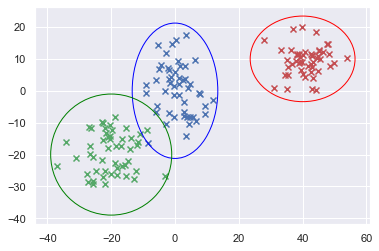

In [13]:
fig, axs = plt.subplots()
draw_ellipse(np.array(mean_1), np.array(cov_1), axs, edgecolor='blue')
draw_ellipse(np.array(mean_2), np.array(cov_2), axs, ifprint=True, edgecolor='green')
draw_ellipse(np.array(mean_3), np.array(cov_3), axs, edgecolor='red')
axs.scatter(X1, Y1, marker='x')
axs.scatter(X2, Y2, marker='x', color='g')
axs.scatter(X3, Y3, marker='x', color='r')
axs.axis('equal')
plt.show()

In [60]:
# mu = np.array([[X1.mean(), Y1.mean()], [X2.mean(), Y2.mean()], [X3.mean(), Y3.mean()]]) + np.random.uniform(-1.5, 1.5, size=(K, D))
# sigma = np.array([np.eye(D) for k in range(K)])

In [61]:
print(mu.shape)
print(sigma.shape)

(3, 2)
(3, 2, 2)


In [64]:
# E_step(w,mu,sigma,X)
this_gamma_nk = E_step(w,mu,sigma,test_X)

In [65]:
this_gamma_nk.shape

(150, 3)

In [66]:
# M_step(X, gamma_nk)
new_w, new_mu, new_sigma = M_step(test_X, this_gamma_nk)

In [68]:
new_mu

array([[ -0.20881957,  -1.19106211],
       [-19.52130049, -20.46294548],
       [ 39.51004128,   9.4615841 ]])

In [70]:
new_sigma

array([[[17.63921315,  1.61797209],
        [ 1.61797209, 38.7104949 ]],

       [[26.18458676, -9.82028538],
        [-9.82028538, 40.43272852]],

       [[45.30265054, -0.21267465],
        [-0.21267465, 25.73012455]]])

ell_radius_x:  0.8355771885805304
ell_radius_y:  1.140969220410374
scale_x:  15.351263166663989
scale_y:  19.07602046304497
mean_x:  -19.52130048760722
mean_y:  -20.462945475525515


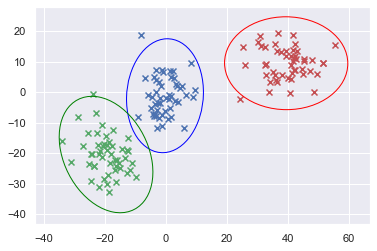

In [71]:
fig, axs = plt.subplots()
draw_ellipse(np.array(new_mu[0]), np.array(new_sigma[0]), axs, edgecolor='blue')
draw_ellipse(np.array(new_mu[1]), np.array(new_sigma[1]), axs, ifprint=True, edgecolor='green')
draw_ellipse(np.array(new_mu[2]), np.array(new_sigma[2]), axs, edgecolor='red')
axs.scatter(X1, Y1, marker='x')
axs.scatter(X2, Y2, marker='x', color='g')
axs.scatter(X3, Y3, marker='x', color='r')
axs.axis('equal')
plt.show()

## Self implementation

In [19]:
# https://en.wikipedia.org/wiki/EM_algorithm_and_GMM_model
# K = 3, i (num_m) = 15
def self_E_step(x, phis, means, covs):
    # w = shape([phi, x]) (3,45)
    w = np.zeros([phis.shape[0], x.shape[0]])
    # phi = the probability for one model
    # multivariate_normal
    for i, xi in enumerate(x):
        below = 0
        for alpha, mean, cov in zip(phis, means, covs):
            this_gaussian = multivariate_normal(mean=mean, cov=cov)
            below += alpha * this_gaussian.pdf(xi)
        
        if below <= 0.0:
            below = 1e-6
        for j, alpha in enumerate(phis):
            this_gaussian = multivariate_normal(mean=means[j], cov=covs[j])
            above = alpha * this_gaussian.pdf(xi)
            # print(above)
            w[j, i] = above / below
    return w

def self_M_step(x, w):
    # w = shape([phi, x]) (3,45)
    # x = array([x1,x2,...,xn]) (45,2)
    
    w_each_sum = np.zeros((w.shape[0]))
    for j in range(w.shape[0]):
        w_each_sum[j] = w[j, :].sum()
    
    phis = w_each_sum / x.shape[0]
    
    mus = np.zeros((w.shape[0],x.shape[1]))
    for j in range(w.shape[0]):
        for i in range(x.shape[0]):
            mus[j] += w[j, i] * x[i]
        mus[j] = mus[j] / w_each_sum[j]
    
    sigma = np.zeros((w.shape[0],x.shape[1],x.shape[1]))
    for j in range(w.shape[0]):
        for i in range(x.shape[0]):
            expand_matrix = np.repeat((x[i] - mus[j])[:,None], x.shape[1], 1)
            sigma[j] += w[j, i] * (expand_matrix * expand_matrix.T)
        sigma[j] = sigma[j] / w_each_sum[j]
    return phis, mus, sigma

def log_likelihood(w, x, phis, means, covs):
    # w = (phi, x)
    value = 0.0
    for i in range(x.shape[0]): # 45
        tmp_value = 0.0
        for j in range(w.shape[0]): # 3
            this_gaussian = multivariate_normal(mean=means[j], cov=covs[j])
            tmp_value += phis[j] * this_gaussian.pdf(x[i])
        value += np.log(tmp_value)
    return value / (x.shape[0] + 1e-6)

In [75]:
mu

array([[ -1.4615141 ,  -0.83845827],
       [-19.98971587, -21.81908424],
       [ 39.90111118,  10.630684  ]])

In [83]:
self_gamma_nk.shape

(3, 150)

In [135]:
self_gamma_nk = self_E_step(test_X,w,mu,sigma)

In [136]:
self_new_w, self_new_mu, self_new_sigma = self_M_step(test_X,self_gamma_nk)

In [95]:
# 原自己寫的演算法a
self_new_sigma

array([[[ 35.2784263 ,   3.23594417],
        [  3.23594417,  77.4209898 ]],

       [[ 52.36917351, -19.64057076],
        [-19.64057076,  80.86545705]],

       [[ 90.60530107,  -0.42534929],
        [ -0.42534929,  51.4602491 ]]])

In [150]:
self_new_mu = mu
self_new_w = w
self_new_sigma = sigma
for i in range(10):
    self_gamma_nk = self_E_step(test_X,self_new_w,self_new_mu,sigma)
    self_new_w, self_new_mu, self_new_sigma = self_M_step(test_X,self_gamma_nk)

ell_radius_x:  0.8355771885680418
ell_radius_y:  1.1409692204195199
scale_x:  15.35126316662386
scale_y:  19.076020464635228
mean_x:  -19.521300487691242
mean_y:  -20.46294547514515


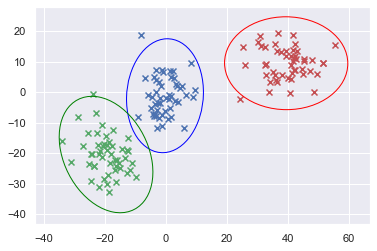

In [143]:
fig, axs = plt.subplots()
draw_ellipse(np.array(self_new_mu[0]), np.array(self_new_sigma[0]), axs, edgecolor='blue')
draw_ellipse(np.array(self_new_mu[1]), np.array(self_new_sigma[1]), axs, ifprint=True, edgecolor='green')
draw_ellipse(np.array(self_new_mu[2]), np.array(self_new_sigma[2]), axs, edgecolor='red')
axs.scatter(X1, Y1, marker='x')
axs.scatter(X2, Y2, marker='x', color='g')
axs.scatter(X3, Y3, marker='x', color='r')
axs.axis('equal')
plt.show()

In [21]:
# 不同 mean initial value
diff_mu = np.array([[10,10],[-10,-10],[10,-10]]).astype(np.float32)
self_new_mu = diff_mu
self_new_w = w
self_new_sigma = sigma
self_gamma_nk = self_E_step(test_X,self_new_w,self_new_mu, self_new_sigma)
loss_val = log_likelihood(self_gamma_nk, test_X, self_new_w, self_new_mu, self_new_sigma)
print("Original log-likelihood: ", loss_val)
for i in range(20):
    self_gamma_nk = self_E_step(test_X,self_new_w,self_new_mu, self_new_sigma)
    self_new_w, self_new_mu, self_new_sigma = self_M_step(test_X,self_gamma_nk)
    
    loss_val = log_likelihood(self_gamma_nk, test_X, self_new_w, self_new_mu, self_new_sigma)
    print("log-likelihood: ", loss_val)

/home/labpc4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


Original log-likelihood:  -inf
log-likelihood:  -7.84874012474342
log-likelihood:  -7.821119793751088
log-likelihood:  -7.816372394366605
log-likelihood:  -7.808422964606934
log-likelihood:  -7.794159558560538
log-likelihood:  -7.771169411093941
log-likelihood:  -7.739278735979329
log-likelihood:  -7.69644595777286
log-likelihood:  -7.633464545012569
log-likelihood:  -7.520796472944696
log-likelihood:  -7.369547950433694
log-likelihood:  -7.363061299356506
log-likelihood:  -7.362848492740163
log-likelihood:  -7.362812426616077
log-likelihood:  -7.362807051852876
log-likelihood:  -7.362806289933172
log-likelihood:  -7.36280618392362
log-likelihood:  -7.362806169276493
log-likelihood:  -7.362806167257988
log-likelihood:  -7.362806166980086


ell_radius_x:  1.0460999935947841
ell_radius_y:  0.9516694822263624
scale_x:  19.755744958667325
scale_y:  18.561858255103708
mean_x:  -19.90944306840804
mean_y:  -19.115137025308183


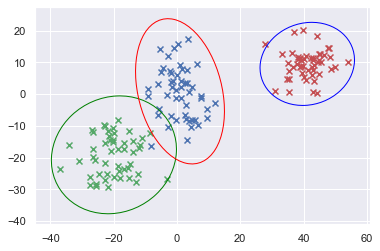

In [22]:
fig, axs = plt.subplots()
draw_ellipse(np.array(self_new_mu[0]), np.array(self_new_sigma[0]), axs, edgecolor='blue')
draw_ellipse(np.array(self_new_mu[1]), np.array(self_new_sigma[1]), axs, ifprint=True, edgecolor='green')
draw_ellipse(np.array(self_new_mu[2]), np.array(self_new_sigma[2]), axs, edgecolor='red')
axs.scatter(X1, Y1, marker='x')
axs.scatter(X2, Y2, marker='x', color='g')
axs.scatter(X3, Y3, marker='x', color='r')
axs.axis('equal')
plt.show()